In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  2 03:36:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Give Google Colab access to your Google Drive containing the dogs and cats data
from google.colab import drive
drive.mount('/content/drive')

# Unzip the data from your Google Drive
!unzip '/content/drive/My Drive/Data Set/dogs-vs-cats-redux-kernels-edition.zip'
!unzip 'dogs-vs-cats-redux-kernels-edition/test.zip'
!unzip 'dogs-vs-cats-redux-kernels-edition/train.zip'

# Make directories containing the data in your current Colab session
!mkdir train/{dog,cat}
!find train -maxdepth 1 -type f | grep 'dog' | xargs -I{} mv {} train/dog
!find train -maxdepth 1 -type f | grep 'cat' | xargs -I{} mv {} train/cat

!mkdir test/images
!find test -maxdepth 1 -type f | xargs -I{} mv {} test/images

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [ ]:
import numpy as np
import os, shutil, pathlib
#Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path("train")
#Directory where we will store our smaller dataset#
new_base_dir = pathlib.Path("cats_vs_dogs_small")

#Utility function to copy cat (and dog) images from index start_index to 
#index end_index to the subdirectory new_base_dir/{subset_name}/cat (and /dog). 
#The "subset_name" will be either "train", "validation", or "test".

def make_subset(subset_name, start_index, end_index):
    for category in ["cat", "dog"]:
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / category / fname, dst=dir /fname)
#Create the training subset with the first 1,000 images of each category.
make_subset("train", start_index=0, end_index=1000)
#Create the validation subset with the next 500 images of each category.
make_subset("validation", start_index=1_000, end_index=1_500)
#Create the test subset with the next 1,000 images of each category.
make_subset("test", start_index=1_500, end_index=2_500)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#The model expects RGB images of size 180 × 180.
inputs = keras.Input(shape=(180, 180, 3))
#Rescale inputs to the [0, 1] range by dividing them by 255.
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8982521662727830568
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12937601686944119987
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#Using image_dataset_from_directory to read images


from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir/"train",
                                             image_size=(180, 180),
                                             batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir/"validation",
                                             image_size=(180, 180),
                                             batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir/"test",
                                             image_size=(180, 180),
                                             batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:

#Displaying the shapes of the data and labels yielded by the Dataset
for data_batch, labels_batch in train_dataset:
    print(f"data_batch.shape = {data_batch.shape}")
    print(f"labels_batch.shape = {labels_batch.shape}")
    break

data_batch.shape = (32, 180, 180, 3)
labels_batch.shape = (32,)


In [ ]:
#Fitting the model using a Dataset
callbacks = keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True, 
    monitor="val_loss"
)

In [ ]:
history = model.fit(train_dataset,
                    epochs=30, 
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 64ms/step - loss: 0.7211 - accuracy: 0.5195 - val_loss: 0.6915 - val_accuracy: 0.5240
Epoch 2/30
63/63 [==============================] - 4s 58ms/step - loss: 0.6878 - accuracy: 0.5725 - val_loss: 0.6483 - val_accuracy: 0.6210
Epoch 3/30
63/63 [==============================] - 4s 54ms/step - loss: 0.6957 - accuracy: 0.6360 - val_loss: 0.6305 - val_accuracy: 0.6430
Epoch 4/30
63/63 [==============================] - 3s 53ms/step - loss: 0.6026 - accuracy: 0.6755 - val_loss: 0.7605 - val_accuracy: 0.6180
Epoch 5/30
63/63 [==============================] - 3s 53ms/step - loss: 0.5753 - accuracy: 0.6920 - val_loss: 0.6320 - val_accuracy: 0.6320
Epoch 6/30
63/63 [==============================] - 4s 54ms/step - loss: 0.5274 - accuracy: 0.7455 - val_loss: 0.6058 - val_accuracy: 0.6970
Epoch 7/30
63/63 [==============================] - 4s 54ms/step - loss: 0.4845 - accuracy: 0.7770 - val_loss: 0.5679 - val_accuracy: 0.7070
Epoch 8/30
6

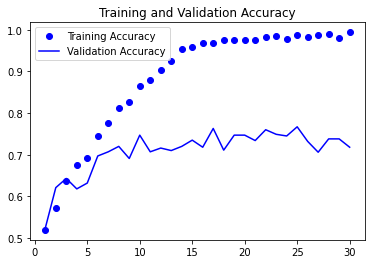

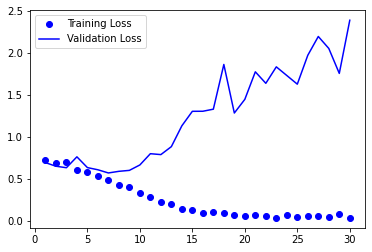

In [ ]:
#Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
#Evaluating the model on the test set
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 22ms/step - loss: 0.5867 - accuracy: 0.7000
Test accuracy: 0.700


In [ ]:
#Define a data augmentation stage to add to an imag
data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)
])

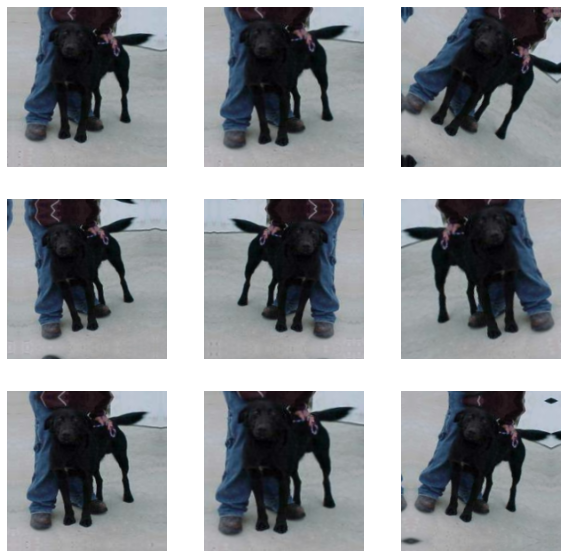

In [ ]:
'Displaying some randomly augmented training images'

#We can use take(N) to only sample N batches from the dataset. 
#This is equivalent to inserting a break in the loop after the Nth batch.
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
      #Apply the augmentation stage to the batch of images.
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        #Display the first image in the output batch. For each of the nine iterations, 
        #this is a different augmentation of the same image.
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:

#Defining a new convnet that includes image augmentation and dropout


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
  
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:

#Training the regularized convnet

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/100
63/63 [==============================] - 6s 60ms/step - loss: 0.7451 - accuracy: 0.5060 - val_loss: 0.6926 - val_accuracy: 0.5480
Epoch 2/100
63/63 [==============================] - 4s 57ms/step - loss: 0.7030 - accuracy: 0.5470 - val_loss: 0.6727 - val_accuracy: 0.5010
Epoch 3/100
63/63 [==============================] - 4s 56ms/step - loss: 0.6662 - accuracy: 0.6060 - val_loss: 0.6959 - val_accuracy: 0.5690
Epoch 4/100
63/63 [==============================] - 4s 57ms/step - loss: 0.6610 - accuracy: 0.6100 - val_loss: 0.6415 - val_accuracy: 0.6140
Epoch 5/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6310 - accuracy: 0.6400 - val_loss: 0.6697 - val_accuracy: 0.6400
Epoch 6/100
63/63 [==============================] - 4s 57ms/step - loss: 0.6248 - accuracy: 0.6620 - val_loss: 0.5865 - val_accuracy: 0.6750
Epoch 7/100
63/63 [==============================] - 4s 56ms/step - loss: 0.6271 - accuracy: 0.6660 - val_loss: 0.6546 - val_accuracy: 0.6300
Epoch 

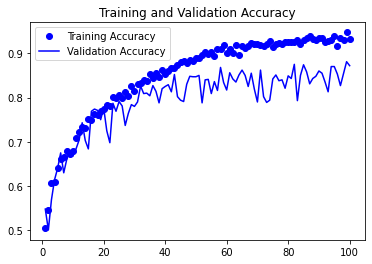

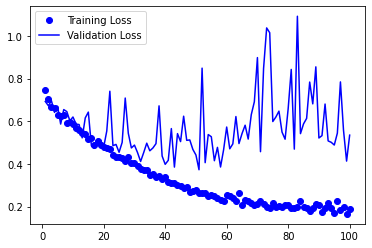

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.legend()
plt.show()

In [ ]:

#Evaluating the model on the test set
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 22ms/step - loss: 0.4087 - accuracy: 0.8415
Test accuracy: 0.841


In [ ]:
#Instantiating the VGG16 convolutional base

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:

#Extracting the VGG16 features and corresponding labels
import numpy as np
  
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)
train_features.shape

(2000, 5, 5, 512)

In [ ]:

'Defining and training the densely connected classifier'
inputs = keras.Input(shape=(5, 5, 512))
#Note the use of the Flatten layer before passing the features to a Dense layer.
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)


outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 17.3016 - accuracy: 0.9285 - val_loss: 21.0012 - val_accuracy: 0.8940
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 5.2356 - accuracy: 0.9685 - val_loss: 5.0298 - val_accuracy: 0.9630
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.0143 - accuracy: 0.9870 - val_loss: 4.2254 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2.1210 - accuracy: 0.9860 - val_loss: 3.0116 - val_accuracy: 0.9810
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8753 - accuracy: 0.9915 - val_loss: 4.0985 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9837 - accuracy: 0.9925 - val_loss: 4.9990 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4033 - accuracy: 0.9955 - val_loss: 5.2014 - val_accuracy: 0.9730
Epoch 8/20
63/63 [

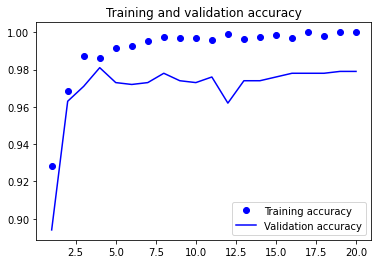

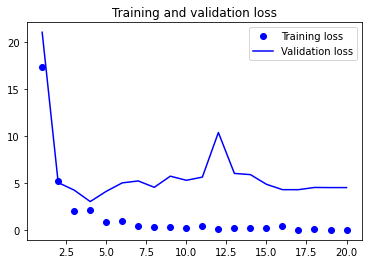

In [ ]:
#Plotting the results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()